In [31]:
import glob
import time
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import numpy as np


urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/courierprime/CourierPrime-Regular.ttf",
    "CourierPrime-Regular.ttf",
)
fe = mpl.font_manager.FontEntry(fname="CourierPrime-Regular.ttf", name="courierprime")
mpl.font_manager.fontManager.ttflist.append(fe)
color_cycle = ["#444444", "#1BBC9B", "#a895bb", "#F06060", "#F3B562", "#80cedb"]
mpl.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler(color=color_cycle),
        "font.family": fe.name,
        "font.size": 12,
        "figure.figsize": (4.5, 4.5 / 1.3),
        "figure.dpi": 100,
        "ytick.left": True,
        "xtick.bottom": True,
        "image.cmap": "gist_yarg",
        "lines.markersize": 1
    }
)

## Load Prompts

In [2]:
topic_categories = ['md', 'spectroscopy', 'bio', 'qm', 'sim', 'cheminf', 'genchem', 'thermo', 'stats', 'plot']
code_categories = ['code', 'human']
lang_categories = ['ch']
keys = ['name', 'language', 'context']

In [3]:
data = None
valid_files = []
def insert_row(r, data):
    if data is None:
        return {k: [v] for k,v in r.items()}
    return  {k: v + [r[k]] for k,v in data.items()}
for fn in glob.glob('../data/**/*.yml'):
    with open(fn, 'r') as f:
        d = yaml.safe_load(f)
        # slice        
        cat_str = d['categories'] 
        d = {k: d[k] for k in keys}
        # duplicate for categories
        tcs = [c for c in topic_categories if c in cat_str]
        ccs = [c for c in code_categories if c in cat_str]
        lcs = [c for c in lang_categories if c in cat_str]
        if len(lcs) == 0:
            lcs = ['en']
        if len(tcs) > 0:
            valid_files.append(fn)
        for tc in tcs:
            for cc in ccs:
                for lc in lcs:
                    d.update({'topic': tc, 'type': cc, 'natlang': lc})                    
                    data = insert_row(d, data)
                    
df = pd.DataFrame.from_dict(data)

In [163]:
df[df.type == 'human'].groupby('topic').count()

,name,language,context,type,natlang
topic,,,,,
bio,2,2,2,2,2
md,3,3,3,3,3
plot,10,10,10,10,10
qm,3,3,3,3,3
sim,5,5,5,5,5
spectroscopy,1,1,1,1,1
stats,1,1,1,1,1


In [4]:
df.groupby('topic').count()
len(valid_files)
paths = ' '.join(valid_files)
temperatures = [0.05, 0.2, 0.5]
models = ['incoder/facebook/incoder-1B', 'incoder/facebook/incoder-6B', 'openai/code-cushman-001', 'openai/code-davinci-002']
model_names = ['incoder-1B', 'incoder-6B', 'cushman', 'davinci']
can_insert = [True, True, False, True]
ks = [5, 1, 5, 5]

## Programmatic Prompts

In [ ]:

for ins, m, mn, k in zip(can_insert, models, model_names, ks):
    for i,t in enumerate(temperatures):
        out = f'override_{mn}_{i}.csv'
        print(out)
        !nlcc-bench $paths $out --n $k --prompt python --temperature $t --engine $m
        out = f'bench_{mn}_{i}.csv'
        !nlcc-bench $paths $out --n $k --temperature $t --engine $m
        if ins:
            out = f'insert_bench_{mn}_{i}.csv'
            !nlcc-bench $paths $out --n $k --prompt insert --temperature $t --engine $m
        out = f'cheader_bench_{mn}_{i}.csv'
        insert_text = '-insert' if ins else ''
        header = f'header{insert_text}:# MIT License\n\n# Copyright (c) 2022 University of Rochester\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m        
        out = f'lheader_bench_{mn}_{i}.csv'
        header = f'header{insert_text}:# This is written by an expert Python programmer\n\n'
        !nlcc-bench $paths $out --n $k --prompt "$header" --temperature $t --engine $m


In [ ]:
merged = None
for i,t in enumerate(temperatures):
    for ins, m, mn in zip(can_insert, models, model_names):
        f = f'override_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = 'none'
        if merged is None:
            merged = bf
        else:
            merged = pd.concat((merged, bf))
        f = f'bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        merged = pd.concat((merged, bf))
        if ins:
            f = f'insert_bench_{mn}_{i}.csv'
            bf = pd.read_csv(f, delim_whitespace=True) 
            bf = pd.merge(bf, df, how='inner', on='name')
            bf.context.values[:] = [v + '-insert' for v in bf.context.values[:]]
            merged = pd.concat((merged, bf))
        f = f'cheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-copyright' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
        f = f'lheader_bench_{mn}_{i}.csv'
        bf = pd.read_csv(f, delim_whitespace=True)    
        bf = pd.merge(bf, df, how='inner', on='name')
        bf.context.values[:] = [v + '-authority' for v in bf.context.values[:]]
        merged = pd.concat((merged, bf))
def short_context(c):
    if c == 'none':
        return c
    elif 'copyright' in c:
        return 'copyright'
    elif 'authority' in c:
        return 'authority'
    elif 'insert' in c:
        return 'insert'
    return 'custom'

def short_model(c):
    i = models.index(c)
    return model_names[i]
    
merged = merged.assign(used_context=merged.context.apply(short_context))
merged = merged.assign(model=merged.engine.apply(short_model))
merged.to_pickle('promp_results.pkl')
merged.tail()

In [134]:
merged = pd.read_pickle('promp_results.pkl')

In [135]:
merged[merged.type == 'human']

,name,result,temperature,engine,language,context,topic,type,natlang,used_context,model
130,gaussian_input_emin,1,0.05,incoder/facebook/incoder-1B,python,none,qm,human,en,none,incoder-1B
131,gaussian_input_emin,1,0.05,incoder/facebook/incoder-1B,python,none,qm,human,en,none,incoder-1B
132,gaussian_input_emin,1,0.05,incoder/facebook/incoder-1B,python,none,qm,human,en,none,incoder-1B
133,gaussian_input_emin,1,0.05,incoder/facebook/incoder-1B,python,none,qm,human,en,none,incoder-1B
134,gaussian_input_emin,1,0.05,incoder/facebook/incoder-1B,python,none,qm,human,en,none,incoder-1B
...,...,...,...,...,...,...,...,...,...,...,...
335,protein-render,0,0.50,openai/code-davinci-002,python,mdtraj-authority,bio,human,en,authority,davinci
336,protein-render,0,0.50,openai/code-davinci-002,python,mdtraj-authority,bio,human,en,authority,davinci
337,protein-render,0,0.50,openai/code-davinci-002,python,mdtraj-authority,bio,human,en,authority,davinci
338,protein-render,0,0.50,openai/code-davinci-002,python,mdtraj-authority,bio,human,en,authority,davinci


In [110]:
# get dummy row for plotting (to fill empty space)
tmp = merged[merged.topic == 'plot']
tmp.result.values[:] = -1
tmp.topic.values[:] = ''
merged = merged[merged.type == 'code']
merged = pd.concat((merged, tmp))
merged = merged.reset_index(drop=True)

<Figure size 270x270 with 0 Axes>

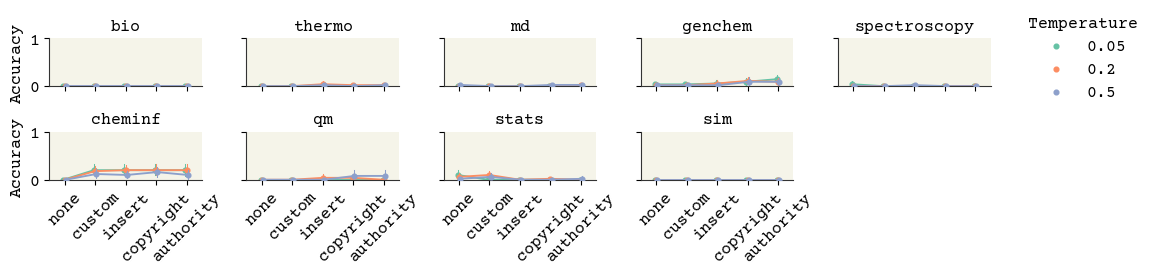

<Figure size 270x270 with 0 Axes>

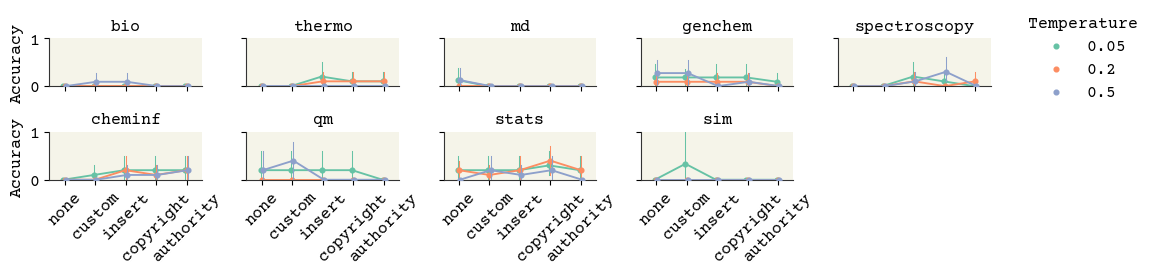

<Figure size 270x270 with 0 Axes>

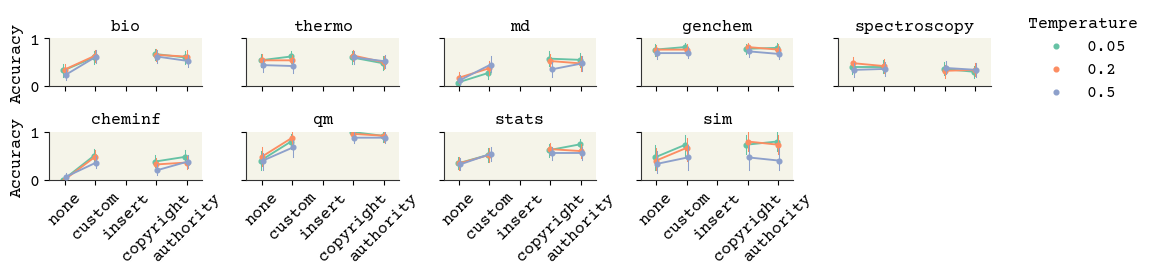

<Figure size 270x270 with 0 Axes>

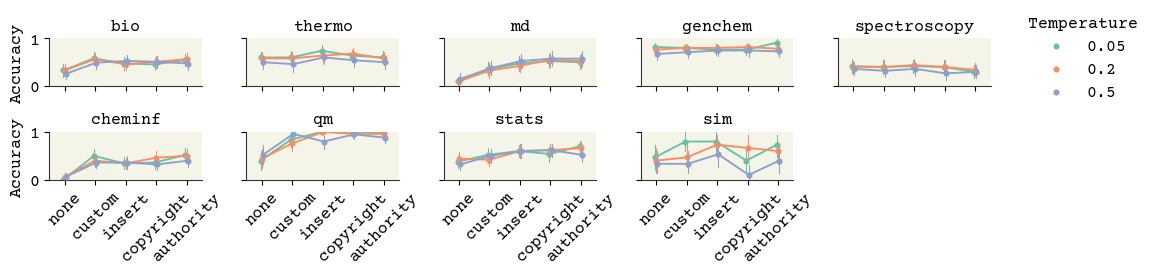

In [111]:
context_order = ['none', 'custom', 'insert', 'copyright', 'authority']

for mn in model_names:
    plt.figure(figsize=(3,3), dpi=90)
    g = sns.FacetGrid(merged[merged.model == mn], col='topic', col_wrap=5, height=1.4, aspect=1.5, hue_order=temperatures)
    g.map(sns.pointplot, 'used_context', 'result', 'temperature', 
          palette='Set2', dodge=True, hue_order=temperatures, order=context_order, scale=0.5, errwidth=0.75)
    g.add_legend(title='Temperature', loc='upper left', bbox_to_anchor=(0.87, 1))
    g.set_axis_labels('', 'Accuracy')    
    g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))    
    g.map(lambda **kwargs: plt.gca().set_ylim(0,1))    
    plt.gcf().delaxes(g.axes[-1])
    g.set_titles('{col_name}')
    g.savefig(f'{mn}-accuracy.pdf')
    g.savefig(f'{mn}-accuracy.png', dpi=300)


<Figure size 270x270 with 0 Axes>

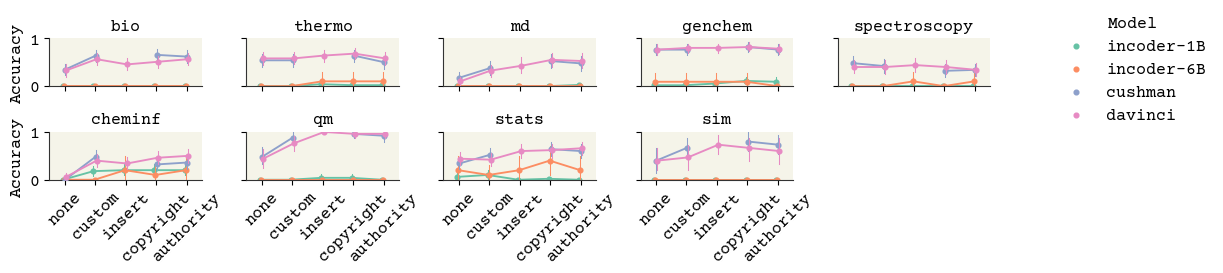

In [112]:
plt.figure(figsize=(3,3), dpi=90)
g = sns.FacetGrid(merged[merged.temperature == 0.2], col='topic', 
                  col_wrap=5, height=1.4, aspect=1.5, hue_order=model_names)
g.map(sns.pointplot, 'used_context', 'result', 'model', hue_order=model_names, order=context_order,
      palette='Set2', dodge=True,  scale=0.5, errwidth=0.75)
g.add_legend(title='Model', loc='upper left', bbox_to_anchor=(0.87, 1))
g.set_axis_labels('', 'Accuracy')
g.map(lambda **kwargs: plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45))
g.map(lambda **kwargs: plt.gca().set_ylim(0,1))    
plt.gcf().delaxes(g.axes[-1])
g.set_titles('{col_name}')
g.savefig('model-comparison.pdf')
g.savefig('model-comparison.png', dpi=300)

In [9]:
print(df.groupby('topic').count().iloc[:,0].to_latex())

\begin{tabular}{lr}
\toprule
{} &  name \\
topic        &       \\
\midrule
bio          &    13 \\
cheminf      &    10 \\
genchem      &    11 \\
md           &    11 \\
plot         &    10 \\
qm           &     8 \\
sim          &     8 \\
spectroscopy &    11 \\
stats        &    11 \\
thermo       &    10 \\
\bottomrule
\end{tabular}



In [138]:
# now remove, because we do not need the plotting dummy
merged = merged[merged.type == 'code']

<Figure size 270x270 with 0 Axes>

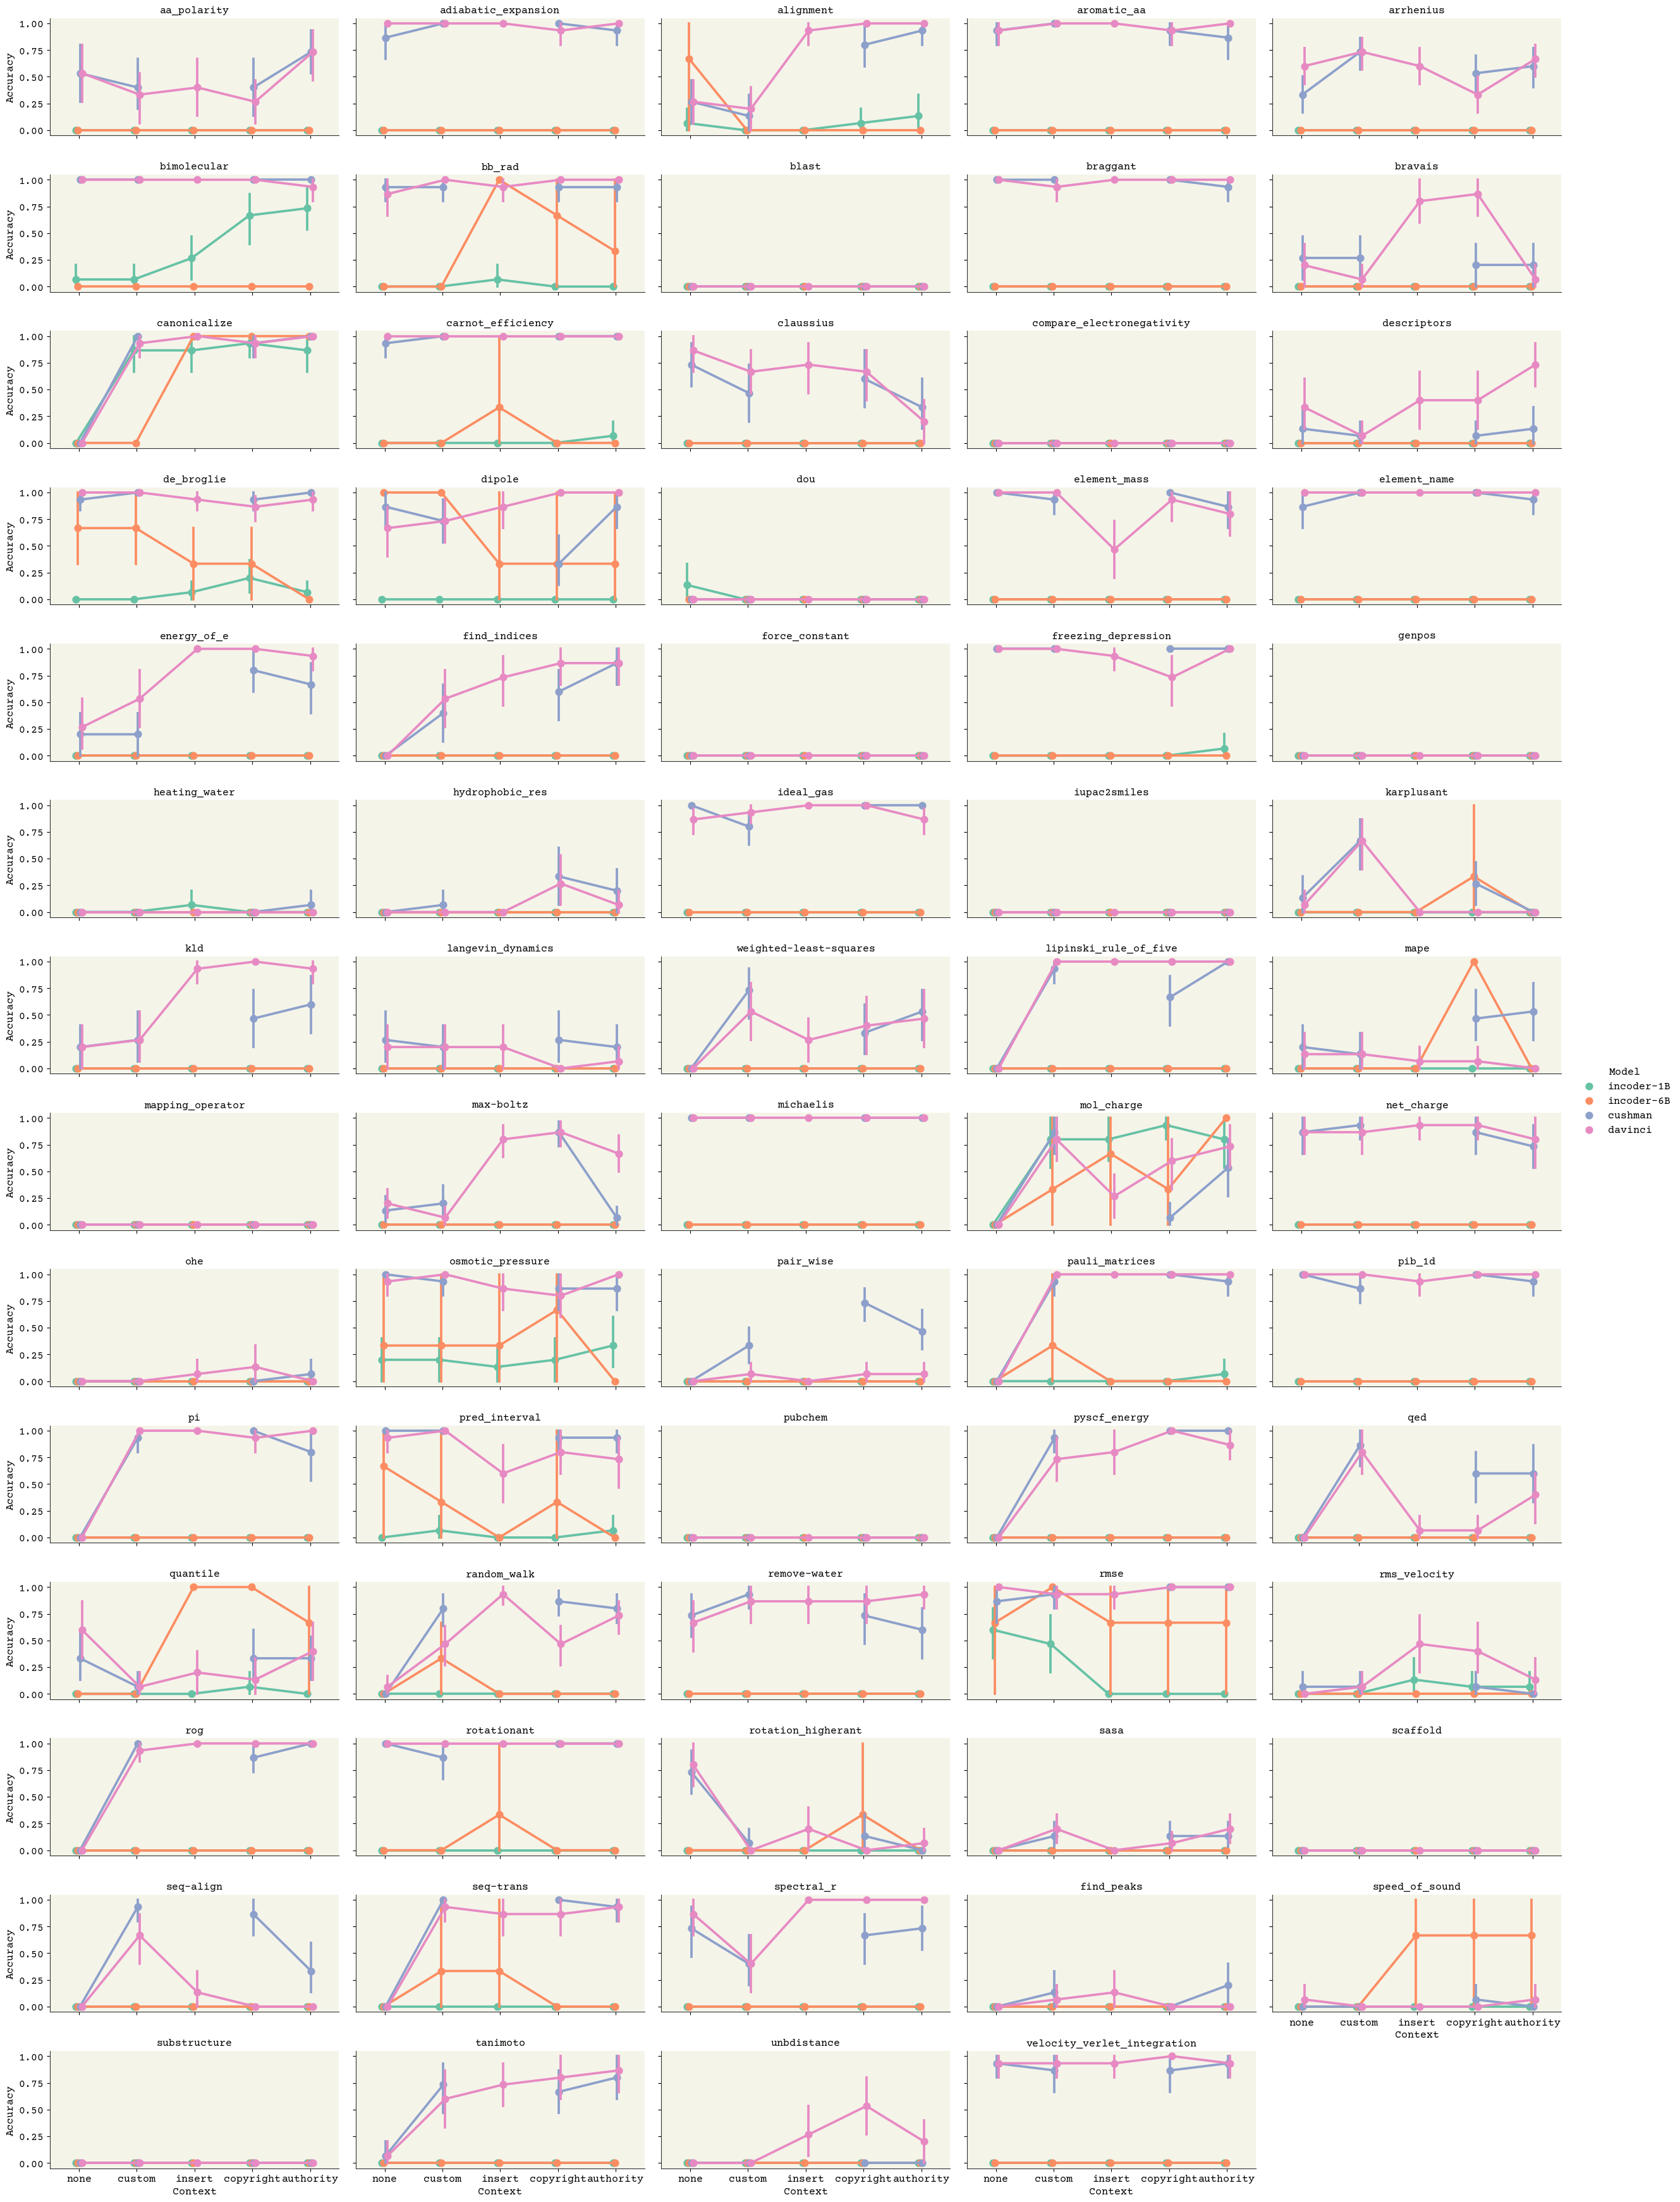

In [173]:
plt.figure(figsize=(3,3), dpi=90)
g = sns.FacetGrid(merged, col='name', col_wrap=5, height=2.5, aspect=2, hue_order=model_names)
g.map(sns.pointplot, 'used_context', 'result', 'model',  hue_order=model_names, order=context_order,
      palette='Set2', dodge=True, fontsize=18)
g.add_legend(title='Model')
g.set_axis_labels('Context', 'Accuracy')
g.set_titles('{col_name}')
g.savefig('all.pdf')
g.savefig('all.png', dpi=300)

In [123]:
print(context_order)

['none', 'custom', 'insert', 'copyright', 'authority']


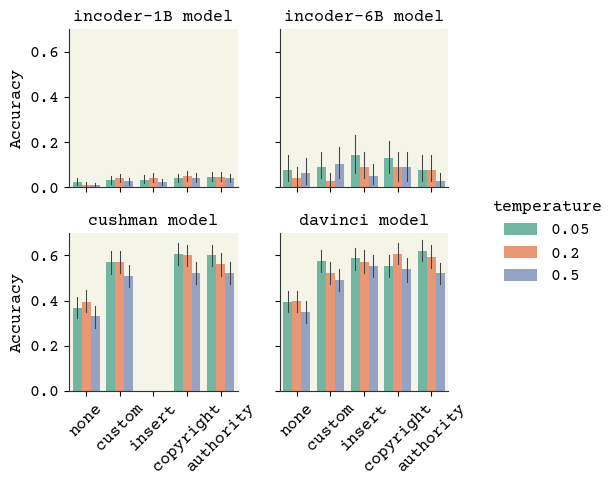

In [172]:
g = sns.catplot(
    data=merged, kind="bar", col="model",
    x="used_context", y="result", hue="temperature",
    palette="Set2", alpha=1, height=2.5, col_wrap=2, order=context_order, errwidth=0.75
)
g.set_axis_labels('', 'Accuracy')
g.map(lambda **kwargs: plt.gca().set_xticklabels(context_order, rotation=45))
g.set_titles('{col_name} model')
g.savefig('context.pdf')
g.savefig('context.png', dpi=300)

In [167]:
print(merged[(merged.model == 'incoder-6B') & (merged.used_context == 'copyright')].\
groupby('name').max().groupby('topic').mean()['result'].to_latex())
print(merged[(merged.model == 'incoder-6B') & (merged.used_context == 'none')].\
groupby('name').max().groupby('topic').mean()['result'].mean())

\begin{tabular}{lr}
\toprule
{} &    result \\
topic        &           \\
\midrule
bio          &  0.000000 \\
cheminf      &  0.200000 \\
genchem      &  0.285714 \\
md           &  0.000000 \\
qm           &  0.200000 \\
sim          &  0.000000 \\
spectroscopy &  0.300000 \\
stats        &  0.400000 \\
thermo       &  0.100000 \\
\bottomrule
\end{tabular}

0.09007936507936508


In [117]:
len(merged['name'].unique())

79

In [145]:
print(merged[(merged.model == 'davinci') & (merged.used_context == 'insert')].\
groupby('name').max().groupby('topic').mean()['result'].to_latex())
print(merged[(merged.model == 'davinci') & (merged.used_context == 'insert')].\
groupby('name').max().groupby('topic').mean()['result'].mean())

\begin{tabular}{lr}
\toprule
{} &    result \\
topic        &           \\
\midrule
bio          &  0.714286 \\
cheminf      &  0.600000 \\
genchem      &  0.857143 \\
md           &  0.625000 \\
qm           &  1.000000 \\
sim          &  1.000000 \\
spectroscopy &  0.600000 \\
stats        &  1.000000 \\
thermo       &  0.800000 \\
\bottomrule
\end{tabular}

0.7996031746031746
